In [5]:
server = 'obi'
logBoth = False

dataDir = "/home/ubuntu/data/competitiondata/"
if logBoth:
    dataSave = "/home/ubuntu/data/ptDecoder_ctc_both"
else:
    dataSave = "/home/ubuntu/data/ptDecoder_ctc"
    

print(dataDir, dataSave)

/home/ubuntu/data/competitiondata/ /home/ubuntu/data/ptDecoder_ctc


In [19]:
import pickle 
file1 = "/home/ubuntu/data/ptDecoder_ctc"
file2 = "/home/ubuntu/data/ptDecoder_ctc_both"

with open(file1, "rb") as f:
    data1 = pickle.load(f)

with open(file2, "rb") as f:
    data2 = pickle.load(f)


In [28]:
data1['train'][0]['sentenceDat'][0][0][0]

0.7482294

In [29]:
data2['train'][0]['sentenceDat'][0][0][0]

0.91912067

In [6]:
import nltk
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /home/ubuntu/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [7]:
sessionNames = ['t12.2022.04.28',  't12.2022.05.26',  't12.2022.06.21',  't12.2022.07.21',  't12.2022.08.13',
't12.2022.05.05',  't12.2022.06.02',  't12.2022.06.23',  't12.2022.07.27',  't12.2022.08.18',
't12.2022.05.17',  't12.2022.06.07',  't12.2022.06.28',  't12.2022.07.29',  't12.2022.08.23',
't12.2022.05.19',  't12.2022.06.14',  't12.2022.07.05',  't12.2022.08.02',  't12.2022.08.25',
't12.2022.05.24',  't12.2022.06.16',  't12.2022.07.14',  't12.2022.08.11']
sessionNames.sort()

In [8]:
import re 
from g2p_en import G2p
import numpy as np

g2p = G2p()
PHONE_DEF = [
    'AA', 'AE', 'AH', 'AO', 'AW',
    'AY', 'B',  'CH', 'D', 'DH',
    'EH', 'ER', 'EY', 'F', 'G',
    'HH', 'IH', 'IY', 'JH', 'K',
    'L', 'M', 'N', 'NG', 'OW',
    'OY', 'P', 'R', 'S', 'SH',
    'T', 'TH', 'UH', 'UW', 'V',
    'W', 'Y', 'Z', 'ZH'
]
PHONE_DEF_SIL = PHONE_DEF + ['SIL']

def phoneToId(p):
    return PHONE_DEF_SIL.index(p)

In [9]:
def reorder_electrode_idxs(feats):
    
    '''
    In the original array, first 128 indices of feats are txcrossings, 
    second 128 features are spikeband power.
    Here what we do is rearrange feats so that:
        0-64: tx for inferior
        64-128: spikepow for inferior
        128-194: tx for superior
        194-256: spikepow for superior
    '''
    
    area_6v_superior = np.array([
    [62,  51,  43,  35,  94,  87,  79,  78],
    [60,  53,  41,  33,  95,  86,  77,  76],
    [63,  54,  47,  44,  93,  84,  75,  74],
    [58,  55,  48,  40,  92,  85,  73,  72],
    [59,  45,  46,  38,  91,  82,  71,  70],
    [61,  49,  42,  36,  90,  83,  69,  68],
    [56,  52,  39,  34,  89,  81,  67,  66],
    [57,  50,  37,  32,  88,  80,  65,  64]
    ])
    
    superior_combined_array = np.empty(area_6v_superior.size * 2, dtype=area_6v_superior.dtype)  
    
    # first 64 features are tx, second 64 are spikeband power
    superior_combined_array[:64] = area_6v_superior.ravel()
    superior_combined_array[64:] = area_6v_superior.ravel() + 128   

    area_6v_inferior = np.array([
        [125, 126, 112, 103,  31,  28,  11,  8],
        [123, 124, 110, 102,  29,  26,   9,  5],
        [121, 122, 109, 101,  27,  19,  18,  4],
        [119, 120, 108, 100,  25,  15,  12,  6],
        [117, 118, 107,  99,  23,  13,  10,  3],
        [115, 116, 106,  97,  21,  20,   7,  2],
        [113, 114, 105,  98,  17,  24,  14,  0],
        [127, 111, 104,  96,  30,  22,  16,  1]
    ])
    
    inferior_combined_array = np.empty(area_6v_inferior.size * 2, dtype=area_6v_inferior.dtype)  
    inferior_combined_array[:64] = area_6v_inferior.ravel()
    inferior_combined_array[64:] = area_6v_inferior.ravel() + 128   
    
    feats_reshaped = np.zeros_like(feats)
    
    feats_reshaped[:, 0:128] = feats[:, inferior_combined_array.ravel()]
    feats_reshaped[:, 128:] = feats[:, superior_combined_array.ravel()]
    
    return feats_reshaped
    

In [10]:
import scipy

def loadFeaturesAndNormalize(sessionPath, logBoth):
    
    dat = scipy.io.loadmat(sessionPath)

    input_features = []
    transcriptions = []
    frame_lens = []
    block_means = []
    block_stds = []
    n_trials = dat['sentenceText'].shape[0]

    #collect area 6v tx1 and spikePow features
    for i in range(n_trials):    
        #get time series of TX and spike power for this trial
        #first 128 columns = area 6v only
        if logBoth:
            tx_crossings = np.log1p(dat['tx1'][0, i][:, 0:128])
            log_pow = np.log(dat['spikePow'][0,i][:,0:128])
            features = np.concatenate([tx_crossings, log_pow], axis=1)
        else:
            features = np.concatenate([dat['tx1'][0,i][:,0:128], dat['spikePow'][0,i][:,0:128]], axis=1)

        sentence_len = features.shape[0]
        sentence = dat['sentenceText'][i].strip()

        input_features.append(features)
        transcriptions.append(sentence)
        frame_lens.append(sentence_len)

    #block-wise feature normalization
    blockNums = np.squeeze(dat['blockIdx'])
    blockList = np.unique(blockNums)
    blocks = []
    for b in range(len(blockList)):
        sentIdx = np.argwhere(blockNums==blockList[b])
        sentIdx = sentIdx[:,0].astype(np.int32)
        blocks.append(sentIdx)

    for b in range(len(blocks)):
        feats = reorder_electrode_idxs(np.concatenate(input_features[blocks[b][0]:(blocks[b][-1]+1)], axis=0))
        # feats = np.concatenate(input_features[blocks[b][0]:(blocks[b][-1]+1)], axis=0)

        feats_mean = np.mean(feats, axis=0, keepdims=True)
        feats_std = np.std(feats, axis=0, keepdims=True)
        for i in blocks[b]:
            input_features[i] = reorder_electrode_idxs(input_features[i])
            input_features[i] = (input_features[i] - feats_mean) / (feats_std + 1e-8)

    #convert to tfRecord file
    session_data = {
        'inputFeatures': input_features,
        'transcriptions': transcriptions,
        'frameLens': frame_lens
    }

    return session_data


In [11]:
import os

def getDataset(fileName, logBoth):
    
    session_data = loadFeaturesAndNormalize(fileName, logBoth)
        
    allDat = []
    trueSentences = []
    seqElements = []
    
    for x in range(len(session_data['inputFeatures'])):
        allDat.append(session_data['inputFeatures'][x])
        trueSentences.append(session_data['transcriptions'][x])
        
        thisTranscription = str(session_data['transcriptions'][x]).strip()
        thisTranscription = re.sub(r'[^a-zA-Z\- \']', '', thisTranscription)
        thisTranscription = thisTranscription.replace('--', '').lower()
        addInterWordSymbol = True

        phonemes = []
        for p in g2p(thisTranscription):
            if addInterWordSymbol and p==' ':
                phonemes.append('SIL')
            p = re.sub(r'[0-9]', '', p)  # Remove stress
            if re.match(r'[A-Z]+', p):  # Only keep phonemes
                phonemes.append(p)

        #add one SIL symbol at the end so there's one at the end of each word
        if addInterWordSymbol:
            phonemes.append('SIL')

        seqLen = len(phonemes)
        maxSeqLen = 500
        seqClassIDs = np.zeros([maxSeqLen]).astype(np.int32)
        seqClassIDs[0:seqLen] = [phoneToId(p) + 1 for p in phonemes]
        seqElements.append(seqClassIDs)

    newDataset = {}
    newDataset['sentenceDat'] = allDat
    newDataset['transcriptions'] = trueSentences
    newDataset['phonemes'] = seqElements
    
    timeSeriesLens = []
    phoneLens = []
    for x in range(len(newDataset['sentenceDat'])):
        timeSeriesLens.append(newDataset['sentenceDat'][x].shape[0])
        
        zeroIdx = np.argwhere(newDataset['phonemes'][x]==0)
        phoneLens.append(zeroIdx[0,0])
    
    newDataset['timeSeriesLens'] = np.array(timeSeriesLens)
    newDataset['phoneLens'] = np.array(phoneLens)
    newDataset['phonePerTime'] = newDataset['phoneLens'].astype(np.float32) / newDataset['timeSeriesLens'].astype(np.float32)
    return newDataset

In [12]:
trainDatasets = []
testDatasets = []
competitionDatasets = []

print(len(sessionNames))
for dayIdx in range(len(sessionNames)):
    print(dayIdx)
    trainDataset = getDataset(dataDir + '/train/' + sessionNames[dayIdx] + '.mat', logBoth)
    testDataset = getDataset(dataDir + '/test/' + sessionNames[dayIdx] + '.mat', logBoth)

    trainDatasets.append(trainDataset)
    testDatasets.append(testDataset)

    if os.path.exists(dataDir + '/competitionHoldOut/' + sessionNames[dayIdx] + '.mat'):
        dataset = getDataset(dataDir + '/competitionHoldOut/' + sessionNames[dayIdx] + '.mat', logBoth)
        competitionDatasets.append(dataset)

24
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


In [13]:
import pickle

allDatasets = {}
allDatasets['train'] = trainDatasets
allDatasets['test'] = testDatasets
allDatasets['competition'] = competitionDatasets

with open(dataSave, 'wb') as handle:
    pickle.dump(allDatasets, handle)

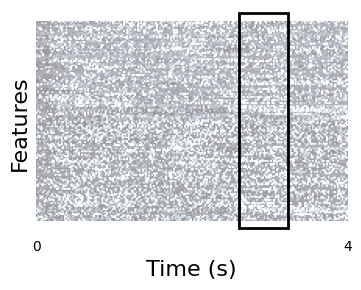

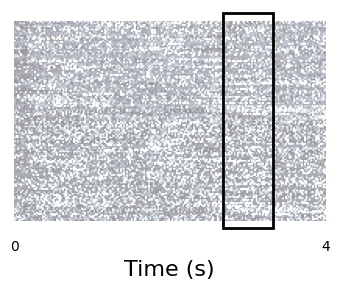

In [14]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

data = trainDatasets[0]['sentenceDat'][10].T
np.save('figure1_neural_data', data)

plt.figure(figsize=(5, 3))
plt.imshow(trainDatasets[0]['sentenceDat'][10].T[:128, 0:200], clim=[-1, 1], alpha=0.4, cmap='bone')
plt.xlabel("Time (s)", fontsize=16)
plt.ylabel("Features", fontsize=16)
plt.tick_params(axis='x', length=0)
plt.xticks([0, 200], [0, 4])
plt.yticks([])


# Transparent rectangle
rect = patches.Rectangle((130, -5), 32, 138,
                         facecolor='none', edgecolor='black', linewidth=2, clip_on=False)
plt.gca().add_patch(rect)


# Adjust y-limits to show full rectangle
plt.ylim(-10, 135)

# Despine all axes
for spine in plt.gca().spines.values():
    spine.set_visible(False)

plt.tight_layout()
plt.show()

import matplotlib.pyplot as plt
import matplotlib.patches as patches

plt.figure(figsize=(5, 3))
plt.imshow(trainDatasets[0]['sentenceDat'][10].T[:128, 0:200], clim=[-1, 1], alpha=0.4, cmap='bone')
plt.xlabel("Time (s)", fontsize=16)
plt.ylabel("")
plt.tick_params(axis='x', length=0)
plt.xticks([0, 200], [0, 4])
plt.yticks([])


# Transparent rectangle
rect = patches.Rectangle((134, -5), 32, 138,
                         facecolor='none', edgecolor='black', linewidth=2, clip_on=False)
plt.gca().add_patch(rect)


# Adjust y-limits to show full rectangle
plt.ylim(-10, 135)

# Despine all axes
for spine in plt.gca().spines.values():
    spine.set_visible(False)

plt.tight_layout()
plt.show()



In [15]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

data = trainDatasets[0]['sentenceDat'][10].T[:64, :260]


fig, ax = plt.subplots(figsize=(5,4))
ax.imshow(data, vmin=-1, vmax=1, origin='lower', alpha=0.6)
ax.set_yticks([])
centers = [60, 130, 200]
rect_width = 20
rect_height = data.shape[0]  # full height of the electrode axis

# Add rectangles
y_start = -0.5  # start slightly below the image
rect_height = data.shape[0] + 1  # extend slightly beyond top

for x_center in centers:
    rect = patches.Rectangle((x_center - rect_width / 2, y_start), rect_width, rect_height,
                             linewidth=0, facecolor='white', alpha=1.0)
    ax.add_patch(rect)
sns.despine(trim=True, top=True, right=True, left=True, bottom=True)

# Set x-ticks at the edges of each patch
ax.set_xticks([])
tick_positions = [0, 50, 70, 120, 140, 190, 210, 260]
tick_positions = [2, 48, 72, 118, 142, 188, 212, 258]
ax.set_xticks(tick_positions)
tick_labels = np.array([0, 50, 50, 100, 100, 150, 150, 200])/10 # 4 labels for the 4 patches
ax.set_xticklabels([str(int(lbl)) for lbl in tick_labels])
ax.tick_params(axis='x', length=0)  # Set tick mark length to 0 on x-axis
ax.tick_params(axis='x', labelsize=12)  

ax.set_xlabel("Timesteps", fontsize=16)

plt.ylim(-0.5, data.shape[0] + 0.5)
plt.tight_layout()
plt.show()



fig, ax = plt.subplots(figsize=(5,4))
ax.imshow(data, vmin=-1, vmax=1, origin='lower', alpha=0.6)
ax.set_yticks([])
centers = [60, 130, 200]
rect_width = 20
rect_height = data.shape[0]  # full height of the electrode axis

# Add rectangles
y_start = -0.5  # start slightly below the image
rect_height = data.shape[0] + 1  # extend slightly beyond top

for x_center in centers:
    rect = patches.Rectangle((x_center - rect_width / 2, y_start), rect_width, rect_height,
                             linewidth=0, facecolor='white', alpha=1.0)
    ax.add_patch(rect)
sns.despine(trim=True, top=True, right=True, left=True, bottom=True)

# Set x-ticks at the edges of each patch
ax.set_xticks([])
tick_positions = [0, 50, 70, 120, 140, 190, 210, 260]
tick_positions = [2, 48, 72, 118, 142, 188, 212, 258]
ax.set_xticks(tick_positions)
tick_labels = [0, 32, 4, 36, 8, 40, 12, 44] # 4 labels for the 4 patches
ax.set_xticklabels([str(int(lbl)) for lbl in tick_labels])
ax.tick_params(axis='x', length=0)  # Set tick mark length to 0 on x-axis
ax.tick_params(axis='x', labelsize=12)  

ax.set_xlabel("Timesteps", fontsize=16)

plt.ylim(-0.5, data.shape[0] + 0.5)
plt.tight_layout()
plt.show()

ModuleNotFoundError: No module named 'seaborn'

In [9]:
def combine_dicts(dict1, dict2):
    
    combined_dict = {}
    for key in dict1.keys():
        if key in ['sentenceDat', 'transcriptions', 'phonemes']: 
            combined_dict[key] = dict1[key] + dict2[key]
        else:
            combined_dict[key] = np.concatenate([dict1[key], dict2[key]])
        
    return combined_dict

In [10]:
sessionNames

['t12.2022.04.28',
 't12.2022.05.05',
 't12.2022.05.17',
 't12.2022.05.19',
 't12.2022.05.24',
 't12.2022.05.26',
 't12.2022.06.02',
 't12.2022.06.07',
 't12.2022.06.14',
 't12.2022.06.16',
 't12.2022.06.21',
 't12.2022.06.23',
 't12.2022.06.28',
 't12.2022.07.05',
 't12.2022.07.14',
 't12.2022.07.21',
 't12.2022.07.27',
 't12.2022.07.29',
 't12.2022.08.02',
 't12.2022.08.11',
 't12.2022.08.13',
 't12.2022.08.18',
 't12.2022.08.23',
 't12.2022.08.25']

# Held out days testing

In [11]:
competitionDays = []
for dayIdx in range(len(sessionNames)):
    if os.path.exists(dataDir + '/competitionHoldOut/' + sessionNames[dayIdx] + '.mat'):
        competitionDays.append(dayIdx)
print(competitionDays)

for cd in competitionDays:
    print(sessionNames[cd])

[4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 18, 19, 20]
t12.2022.05.24
t12.2022.05.26
t12.2022.06.02
t12.2022.06.07
t12.2022.06.14
t12.2022.06.16
t12.2022.06.21
t12.2022.06.28
t12.2022.07.05
t12.2022.07.14
t12.2022.07.21
t12.2022.07.27
t12.2022.08.02
t12.2022.08.11
t12.2022.08.13


In [12]:
trainDatasets = []
testDatasets = []
competitionDatasets = []

condition = 1

if condition == 0:
    evaluation_days = ['07.21', '07.27', '08.02', '08.11', '08.13'] 
if condition == 1:
    evaluation_days = ['06.28', '07.05', '07.14', '07.21', '07.27', '08.02', '08.11', '08.13'] 
    
skip_days = ['07.29']

trainCount = 0
evalCount = 0
print(logBoth)
for dayIdx in range(len(sessionNames[:-3])):
    
    if sessionNames[dayIdx][-5:] in skip_days:
        print("Skipping day: ", sessionNames[dayIdx][-5:])
        continue
        
    if sessionNames[dayIdx][-5:] in evaluation_days:
        
        evalCount += 1
        
        print(f"Placing {sessionNames[dayIdx]} in test/comp")
        
        # put both train and test data for held-out days into "test (really val)".
        testDataset1 = getDataset(dataDir + '/train/' + sessionNames[dayIdx] + '.mat', logBoth)
        testDataset2 = getDataset(dataDir + '/test/' + sessionNames[dayIdx] + '.mat', logBoth)
        testDataset = combine_dicts(testDataset1, testDataset2)
        testDatasets.append(testDataset)
        
        # only testing on these held-out days now. 
        if os.path.exists(dataDir + '/competitionHoldOut/' + sessionNames[dayIdx] + '.mat'):
            dataset = getDataset(dataDir + '/competitionHoldOut/' + sessionNames[dayIdx] + '.mat', logBoth)
            competitionDatasets.append(dataset)
            
    else:
        
        trainCount += 1
        
        print(f"Train {sessionNames[dayIdx]} in train")
        
        # put both train and test data for non held-out days into train
        trainDataset1 = getDataset(dataDir + '/train/' + sessionNames[dayIdx] + '.mat', logBoth)
        trainDataset2 = getDataset(dataDir + '/test/' + sessionNames[dayIdx] + '.mat', logBoth)
        trainDataset = combine_dicts(trainDataset1, trainDataset2)
        trainDatasets.append(trainDataset)
        
        
print("Training days: ", trainCount)
print("Eval days: ", evalCount)

False
Train t12.2022.04.28 in train
Train t12.2022.05.05 in train
Train t12.2022.05.17 in train
Train t12.2022.05.19 in train
Train t12.2022.05.24 in train
Train t12.2022.05.26 in train
Train t12.2022.06.02 in train
Train t12.2022.06.07 in train
Train t12.2022.06.14 in train
Train t12.2022.06.16 in train
Train t12.2022.06.21 in train
Train t12.2022.06.23 in train
Placing t12.2022.06.28 in test/comp
Placing t12.2022.07.05 in test/comp
Placing t12.2022.07.14 in test/comp
Placing t12.2022.07.21 in test/comp
Placing t12.2022.07.27 in test/comp
Skipping day:  07.29
Placing t12.2022.08.02 in test/comp
Placing t12.2022.08.11 in test/comp
Placing t12.2022.08.13 in test/comp
Training days:  12
Eval days:  8


In [33]:
import pickle
allDatasets = {}
allDatasets['train'] = trainDatasets
allDatasets['test'] = testDatasets
allDatasets['competition'] = competitionDatasets

if condition == 0: 
    dataSave_held_out_days = f"{dataSave}_held_out_days"
if condition == 1:
    dataSave_held_out_days = f"{dataSave}_held_out_days_big_0"
    
print(dataSave_held_out_days)
with open(dataSave_held_out_days, 'wb') as handle:
    pickle.dump(allDatasets, handle)

In [17]:
print("max day held out 0 ", 24 - 3 - 6 - 1)
print("max day held out 1 ", 24 -9 - 5 - 1)
print("max day held out 2 ", 24 - 15 - 5 - 1)

max day held out 0  14
max day held out 1  9
max day held out 2  3


In [ ]:
import numpy as np
evaluation_days = ['07.21', '07.27', '08.02', 
                 '08.11', '08.13', '07.29', '07.14', '07.05', '06.28', '06.23', '06.21', '06.16', 
                 '06.14', '06.07', '06.02', '05.26', '05.24', '05.19', '05.17', '05.05', '04.28']

sessionNames_days = np.array([x[-5:] for x in sessionNames])
# skipping the last 3 days because they are not historical data. 
for eval_day in evaluation_days:
    
    print(np.argwhere(eval_day==sessionNames_days)[0])
        

In [ ]:
trainDatasets = []
testDatasets = []
competitionDatasets = []

held_out_run_set = 2

all_training_days = sessionNames[:-3] # first four days will be included in all conditions

all_training_days = [x[-5:] for x in all_training_days]

# remove the one silent speaking day and the one equipment failure day
all_training_days.remove('06.23')
all_training_days.remove('07.29')

# in the first condition, include up to the last 5 competition days in the training data
if held_out_run_set == 0:

    # one extra evaluation day here
    evaluation_days = ['07.21', '07.27', '08.02', '08.11', '08.13'] 
    loop_until = -3
    
elif held_out_run_set == 1:
    
    evaluation_days = ['06.16', '06.21', '06.28', '07.05', '07.14']
    
elif held_out_run_set == 2:
    
    evaluation_days = ['05.24', '05.26', '06.02', '06.07', '06.14']

train_days_count = 0
eval_days_count = 0
# skipping the last 3 days because they are not historical data. 
for dayIdx in range(len(sessionNames[:-3])):

    if sessionNames[dayIdx][-5:] in evaluation_days:
        
        eval_days_count += 1

        print("EVAL", sessionNames[dayIdx])
            
        # put both train and test data for held-out days into "test (really val)".
        testDataset1 = getDataset(dataDir + '/train/' + sessionNames[dayIdx] + '.mat', logBoth)
        testDataset2 = getDataset(dataDir + '/test/' + sessionNames[dayIdx] + '.mat', logBoth)
        
        testDataset = combine_dicts(testDataset1, testDataset2)
        testDatasets.append(testDataset)
        
        # only testing on these held-out days now. 
        if os.path.exists(dataDir + '/competitionHoldOut/' + sessionNames[dayIdx] + '.mat'):
            dataset = getDataset(dataDir + '/competitionHoldOut/' + sessionNames[dayIdx] + '.mat', logBoth)
            competitionDatasets.append(dataset)
            
    elif sessionNames[dayIdx][-5:] in all_training_days:
        
        print("TRAIN", sessionNames[dayIdx])
        train_days_count += 1
        
        # put both train and test data for non held-out days into train
        trainDataset1 = getDataset(dataDir + '/train/' + sessionNames[dayIdx] + '.mat', logBoth)
        trainDataset2 = getDataset(dataDir + '/test/' + sessionNames[dayIdx] + '.mat', logBoth)
        trainDataset = combine_dicts(trainDataset1, trainDataset2)
        trainDatasets.append(trainDataset)
        
print(eval_days_count, train_days_count)
        